In [1]:
import os

network_path = os.path.join("networks", "FS_SPN_feed_forward")

input_name = "FS_SPN_feed_forward"
sim_file_gj = os.path.join(network_path, "simulation", f"output-GJ-{input_name}.hdf5")
sim_file_nogj = os.path.join(network_path, "simulation", f"output-noGJ-{input_name}.hdf5")

input_config = f"{input_name}-input.json"
duration=4
osc_freq = 20

In [2]:
from snudda.init import SnuddaInit

from snudda.init.init import SnuddaInit
cnc = SnuddaInit(struct_def={}, network_path=network_path, random_seed=1337,
                 snudda_data="../../../../BasalGangliaData/data/")
# To get only FS density we use 0.013*80500, but then we also have dSPN and iSPN here in network
# so we need to compensate by a factor of 2 (if we have 50% FS, 25% dSPN, 25% iSPN in this test network)
cnc.define_striatum(num_dSPN=20, num_iSPN=20, num_FS=40, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neuron_density=0.013*80500*(1 + 0.5 + 0.5))
cnc.add_population_unit_random("Striatum", "FS", 1.0, 1)
cnc.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Adding neurons: dSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
Writing networks/FS_SPN_feed_forward/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json


In [4]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, verbose=False)
sd.detect()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 114/343 (78 neurons)
Processing hyper voxel : 163/343 (72 neurons)
Processing hyper voxel : 121/343 (72 neurons)
Processing hyper voxel : 170/343 (64 neurons)
Processing hyper voxel : 115/343 (51 neurons)
Processing hyper voxel : 162/343 (44 neurons)
Processing hyper voxel : 164/343 (44 neurons)
Processing hyper voxel : 113/343 (44 neurons)
Processing hyper voxel : 122/343 (43 neurons)
Processing hyper voxel : 120/343 (38 neurons)
Processing hyper voxel : 65/343 (37 neurons)
Processing hyper voxel : 171/343 (36 neurons)
Processing hyper voxel : 169/343 (35 neurons)
Processing hyper voxel : 107/343 (33 neurons)
Processing hyper voxel : 72/343 (32 neurons)
Processing hyper voxel : 156/343 (27 neurons)
Processing hyper voxel : 64/343 (18 neurons)
Processing hyper voxel : 157/343 (17 neurons)
Processi

In [5]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

Read 17696 out of total 17696 synapses
Read 548 out of total 548 gapJunctions


In [6]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=f"{input_name}-input.json",
                 verbose=False)
si.generate()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Loading 80 neurons with 1804 synapses and 125 gap junctions
!!! Warning, combining definition of cortical_background input for neuron iSPN_0 1 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron iSPN_0 1 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron dSPN_0 4 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron dSPN_0 4 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron iSPN_0 6 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron iSPN_0 6 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron dSPN_3 7 (meta modified by input_config)
!!! Warning, combining def

Loading 80 neurons with 1804 synapses and 125 gap junctions


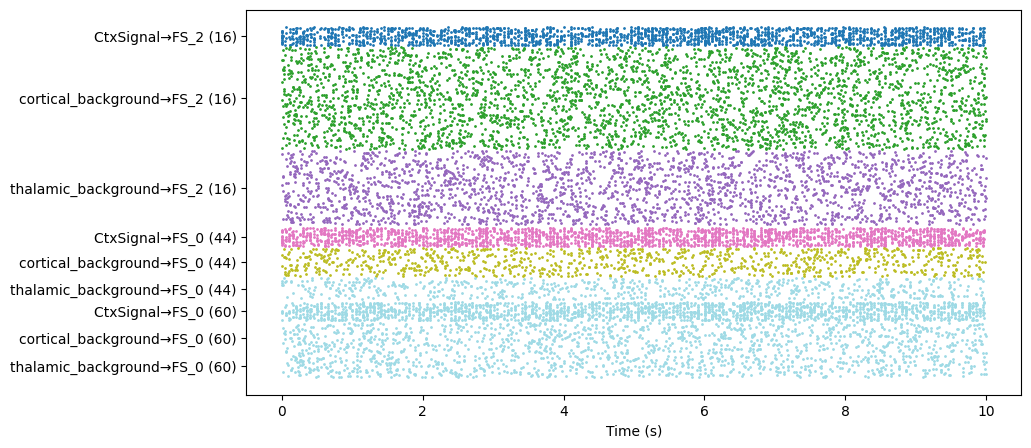

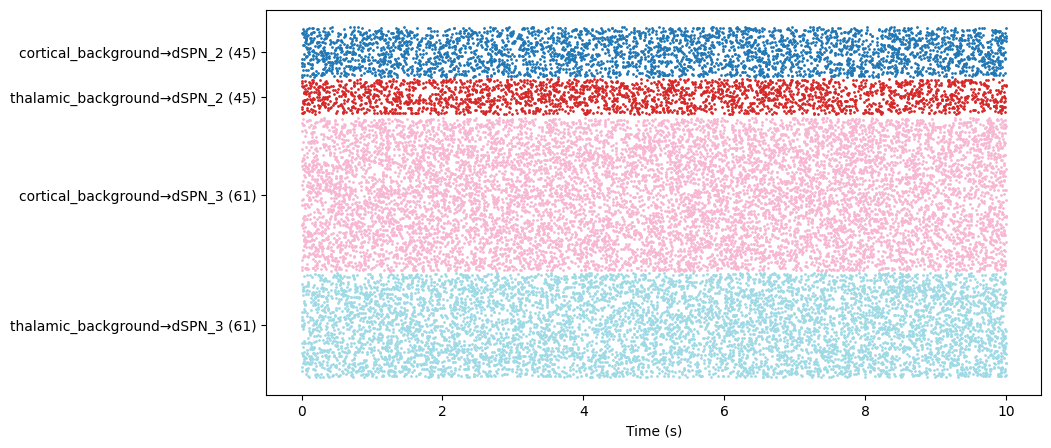

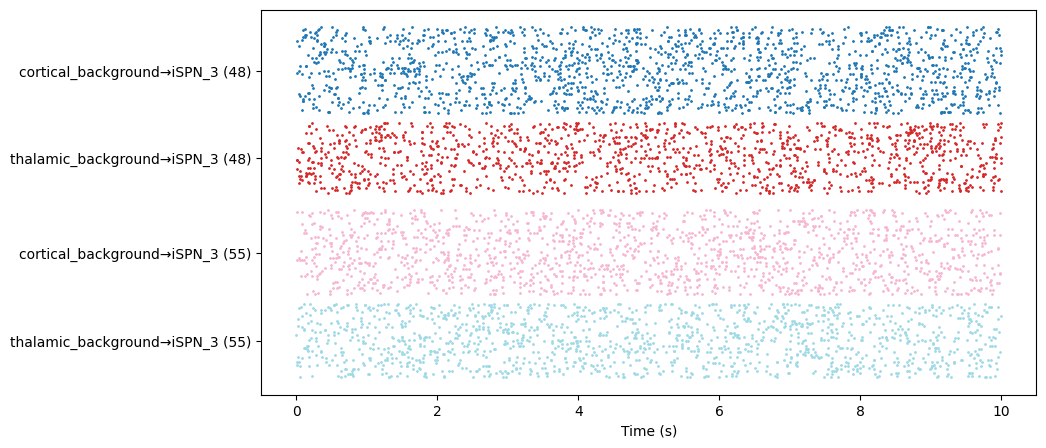

In [7]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)
spi.plot_input(neuron_type="FS", num_neurons=3)
spi.plot_input(neuron_type="dSPN", num_neurons=2)
spi.plot_input(neuron_type="iSPN", num_neurons=2)

In [8]:
os.system(f"mpiexec -n 3 snudda simulate {network_path} --time {duration} --outputFile {sim_file_gj}")

numprocs=3
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Running on master node:  nrnivmodl /home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjo

Traceback (most recent call last):
  File "/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/bluepyopt/ephys/mechanisms.py", line 103, in instantiate
    isec.insert(self.suffix)
ValueError: argument not a density mechanism name.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hjorth/HBP/Snudda/venv/bin/snudda", line 33, in <module>
    sys.exit(load_entry_point('snudda', 'console_scripts', 'snudda')())
  File "/home/hjorth/HBP/Snudda/snudda/cli.py", line 186, in snudda_cli
    actions[args.action](args)
  File "/home/hjorth/HBP/Snudda/snudda/core.py", line 630, in simulate
    sim.setup()
  File "/home/hjorth/HBP/Snudda/snudda/simulate/simulate.py", line 236, in setup
    self.setup_neurons()
  File "/home/hjorth/HBP/Snudda/snudda/simulate/simulate.py", line 518, in setup_neurons
    self.neurons[ID].instantiate(sim=self.sim)
  File "/home/hjorth/HBP/Snudda/snudda/neurons/neuron_model_extended.py", line 426,

256

In [9]:
os.system(f"mpiexec -n 3 snudda simulate {network_path} --time {duration} --outputFile {sim_file_nogj} --disableGJ")

numprocs=3
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Running on master node:  nrnivmodl /home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjo

0

In [10]:
from snudda.utils import SnuddaLoad
from snudda.utils import SnuddaLoadNetworkSimulation

sl = SnuddaLoad(network_path)
sls_gj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_gj)
sls_nogj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_nogj)

nid_fs = sl.get_neuron_id_of_type("FS")
nid_dspn = sl.get_neuron_id_of_type("dSPN")
nid_ispn = sl.get_neuron_id_of_type("iSPN")

Loading 80 neurons with 1804 synapses and 125 gap junctions
Loading networks/FS_SPN_feed_forward/simulation/output-GJ-FS_SPN_feed_forward.hdf5


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'networks/FS_SPN_feed_forward/simulation/output-GJ-FS_SPN_feed_forward.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file_gj)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

In [ ]:
from snudda.plotting.plot_traces import PlotTraces
pt2 = PlotTraces(output_file=sim_file_nogj)
ax2 = pt2.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

In [ ]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file_gj,
                             snudda_load=sl, snudda_simulation_load=sls_gj)

ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, label="FS", color=spr.get_colours("FS"), show_figure=False)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, label="iSPN", ax=ax, color=spr.get_colours("iSPN"))

In [ ]:
spr.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3)

In [ ]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file_nogj,
                             snudda_load=sl, snudda_simulation_load=sls_nogj)

ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, label="FS", color=spr.get_colours("FS"), show_figure=False)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, label="iSPN", ax=ax, color=spr.get_colours("iSPN"))

In [ ]:
spr2.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3)